# Lesson 6 - Generative Modelling Intro (AutoEncoders)

In [ ]:
#|hide
import torch 
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import IPython.display as ipd
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from tglcourse.utils import load_image_pil

# Setting device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

So far in this course we

## Auto-Encoders, Learned Representations and VAEs

We've seen that pre-trained networks can learn representations that are useful for classification. And that we can use some of these learned representations to create a measure of structural or stylistic similarity between images, which we can re-purpose for style transfer. 

How does this idea of learning useful representations tie into generating new images? 

In this section we'll meet something called an autoencoder.

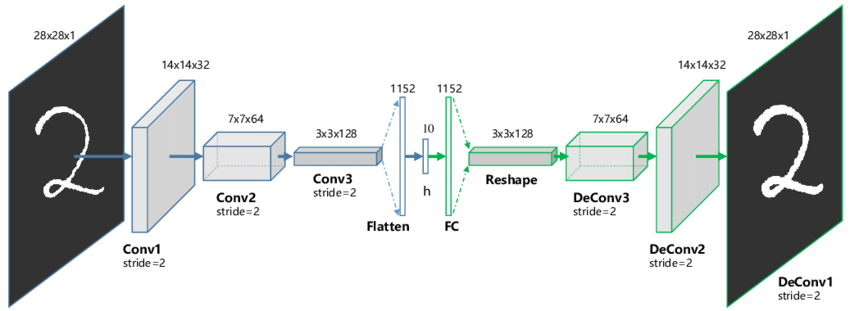

In [ ]:
#|echo: false
# Image source: https://www.researchgate.net/profile/Xifeng-Guo/publication/320658590/figure/fig1/AS:614154637418504@1523437284408/The-structure-of-proposed-Convolutional-AutoEncoders-CAE-for-MNIST-In-the-middle-there.png
load_image_pil('images/ae_diagram.png')

The idea here is to make a neural network with two parts: and encoder and a decoder. The encoder will take an image and process it until, at some point, we reach a 'bottleneck' layer where only a handful of numbers are passed to the next layer. We call this small set of numbers `h` or `z`* or 'the latent representation of the image'. The task of the network during training is to learn how to produce a useful representation so that the decoder can re-create the input image with minimal loss. 

By setting things up in this way, we're forcing the network to learn enough about the data to create a useful representation AND a decoder network that can create nice outputs despite only seeing this very compressed representation of the input image. 

Take a moment to appreciate this: as with many things in deep learning, we don't do anything too special ourselves - we just set an objective and let the network learn how to do things!

*some people are picky about notation, but we'll be fairly flexible and just try to clarify what something is rather than relying too heavily on one poor letter for meaning.

### Creating a Convolutional AutoEncoder

Here we build on the simple networks we made in lesson 3 to create our network. Skim the code and see if you can understand how the encoder and decoder work. Note that `ConvTranspose2d` is effectively the reverse of a convolution layer - check the docs for details.

In [ ]:
class ConvAE(nn.Module):
    def __init__(self, hdim=20):
        super(ConvAE, self).__init__()
        # Encoder layers
        self.enc_conv1 = nn.Conv2d(1, 32, 3)
        self.enc_conv2 = nn.Conv2d(32, 32, 3)
        self.enc_fc1 = nn.Linear(32*24*24, 128)
        self.enc_fc2 = nn.Linear(128, hdim)

        # Decoder layers
        self.dec_fc1 = nn.Linear(hdim, 128)
        self.dec_fc2 = nn.Linear(128, 32*24*24)
        self.dec_unflatten = nn.Unflatten(dim=-1, unflattened_size=(32, 24, 24))
        self.dec_conv1 = nn.ConvTranspose2d(32, 32, 3)
        self.dec_conv2 = nn.ConvTranspose2d(32, 1, 3)

    def encode(self, x):
        x = self.enc_conv1(x)
        x = F.relu(x)
        x = self.enc_conv2(x)
        x = F.relu(x)
        x = torch.flatten(x, 1)
        x = self.enc_fc1(x)
        x = F.relu(x)
        x = self.enc_fc2(x)
        return x

    def decode(self, x):
        x = self.dec_fc1(x)
        x = F.relu(x)
        x = self.dec_fc2(x)
        x = F.relu(x)
        x = self.dec_unflatten(x)
        x = self.dec_conv1(x)
        x = F.relu(x)
        x = self.dec_conv2(x)
        return torch.sigmoid(x) # Sigmoid means the output must be between 0 and 1 (you can explore removing this)

    def forward(self, x):
        return self.decode(self.encode(x))

## Training it on some data

Example image:


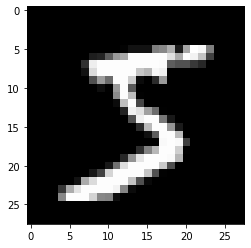

In [ ]:
mnist = datasets.MNIST('./mnist_data/',train=True,transform=transforms.ToTensor(), download=True)
print('Example image:')
plt.imshow(mnist[0][0].squeeze(), cmap='gray');

Input shape: torch.Size([1, 1, 28, 28])
Encoded shape: torch.Size([1, 20])
Decoded shape: torch.Size([1, 1, 28, 28])
Decoded image:


<matplotlib.image.AxesImage>

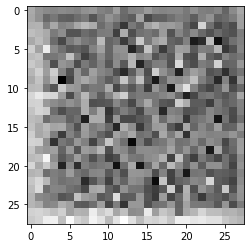

In [ ]:
#|eval: false
# Create a network as defined above and pass an image through it
ae = ConvAE()
x = mnist[0][0].unsqueeze(0)
print('Input shape:', x.shape)
encoded = ae.encode(x)
print('Encoded shape:', encoded.shape)
decoded = ae.decode(encoded)
print('Decoded shape:', decoded.shape)
print('Decoded image:')
plt.imshow(decoded.detach().squeeze(), cmap='gray')

Time to train it. I stole most of this code from the NMA content on this topic, which is where I'd suggest you start if you want to go deeper.

In [ ]:
ae.to(device)
batch_size=128
optim = torch.optim.Adam(ae.parameters(),lr=1e-3,weight_decay=1e-5)
loss_fn = nn.MSELoss()
dataloader = DataLoader(mnist,batch_size=batch_size,shuffle=True, drop_last=True)
for epoch in range(2):
    for im_batch, _ in tqdm(dataloader):
        im_batch = im_batch.to(device)
        optim.zero_grad()
        reconstruction = ae(im_batch) # The forward method encodes and then decodes
        loss = loss_fn(reconstruction.view(batch_size, -1),
                       target=im_batch.view(batch_size, -1))
        loss.backward()
        optim.step()

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

After training, we no longer get the noisy nothingness we saw as the output of the network. Instead, the images look impressively close to the originals! You could try lowering the size of the hidden dimension and seeing how far you can push it.

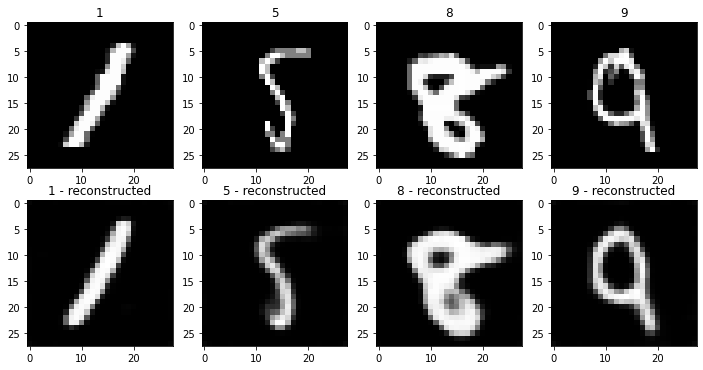

In [ ]:
# Plot the reconstructed versions of some random samples (ideally we'd use examles from a validation set not used for training)
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
for i in range(4):
    im, label = mnist[random.randint(0, len(mnist))]
    axs[0][i].imshow(im.squeeze(), cmap='gray')
    axs[0][i].set_title(label)
    axs[1][i].imshow(ae(im.unsqueeze(0).to(device)).squeeze().detach().cpu(), cmap='gray')
    axs[1][i].set_title(str(label) + ' - reconstructed')

Autoencoders are great, and have many uses (data compression, for example). But they aren't so great at producing new images that look like the training data. Ideally, we'd pick a random point in the latent space (i.e. a set of random numbers to be the `h`) and run it through the decoder to get something that looks like a real image. Instead, if we try this we see mostly strange alien shapes:

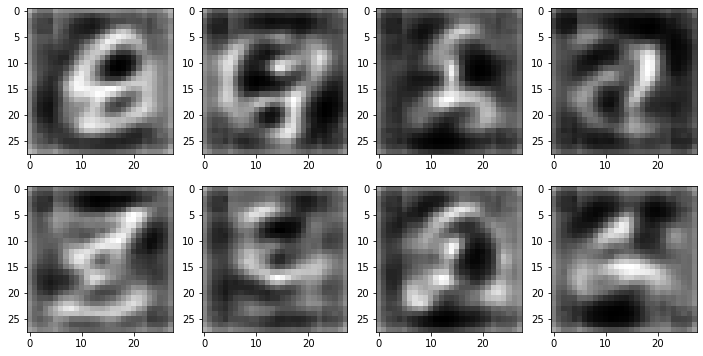

In [ ]:
#|eval: false
# Generate new images from random zs
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
for i in range(8):
    im = ae.decode(torch.randn(1, 20).to(device))
    axs[i//4][i%4].imshow(im.detach().cpu().squeeze(), cmap='gray')

This is because the autoencoder learns to map different image classes to drastically different parts of the latent space - there is no incentive for it to learn a 'neat' representation, only that it learns one that let's it solve the problem as we framed it. 

To 'fix' this, we need to add an additional component to the loss which stops it from keeping all the latent representations wildly separated.

## Variational AutoEncoders

Great explanation: https://www.youtube.com/watch?v=9zKuYvjFFS8

The architecture will be almost identical to the plain AE above, but now our encoder will have two outputs to represent a distribution in the latent space: one for the mean, and one for the standard deviation (or rather, the log of the variance which we can turn into a standard deviation with `torch.exp(0.5*logvar)`). To reconstruct an image, we sample from this distribution to get the hidden representation z which is fed to the decoder, which is unchanged from the previous example.

One subtlety here: reparametrization trick

In [ ]:
class ConvVAE(nn.Module):
    def __init__(self, hdim=20):
        super(ConvVAE, self).__init__()
        # Encoder layers
        self.enc_conv1 = nn.Conv2d(1, 32, 3)
        self.enc_conv2 = nn.Conv2d(32, 32, 3)
        self.enc_fc1 = nn.Linear(32*24*24, 128)
        self.enc_fc2_mean = nn.Linear(128, hdim)
        self.enc_fc2_logvar = nn.Linear(128, hdim)

        # Decoder layers
        self.dec_fc1 = nn.Linear(hdim, 128)
        self.dec_fc2 = nn.Linear(128, 32*24*24)
        self.dec_unflatten = nn.Unflatten(dim=-1, unflattened_size=(32, 24, 24))
        self.dec_conv1 = nn.ConvTranspose2d(32, 32, 3)
        self.dec_conv2 = nn.ConvTranspose2d(32, 1, 3)

    def encode(self, x):
        x = self.enc_conv1(x)
        x = F.relu(x)
        x = self.enc_conv2(x)
        x = F.relu(x)
        x = torch.flatten(x, 1)
        x = self.enc_fc1(x)
        x = F.relu(x)
        mean = self.enc_fc2_mean(x)
        logvar = self.enc_fc2_logvar(x)
        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5*logvar) # 0.5*logvar in the exponent is being fancy. Can do std = torch.sqrt(torch.exp(logvar))
        eps = torch.randn_like(std) # This isn't dependant on mean or logvar
        return mean + eps*std # So we can trace gradients back through this operation

    def decode(self, x):
        x = self.dec_fc1(x)
        x = F.relu(x)
        x = self.dec_fc2(x)
        x = F.relu(x)
        x = self.dec_unflatten(x)
        x = self.dec_conv1(x)
        x = F.relu(x)
        x = self.dec_conv2(x)
        return torch.sigmoid(x) # Clamps value between 0 and 1

    def forward(self, x, return_dist = False):
        mean, logvar = self.encode(x) # Predict a distribution
        z = self.reparameterize(mean, logvar) # Sample from it
        if return_dist: return self.decode(z), mean, logvar 
        return self.decode(z)

In [ ]:
# Some code from https://github.com/pytorch/examples/blob/main/vae/main.py

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

[<matplotlib.lines.Line2D>]

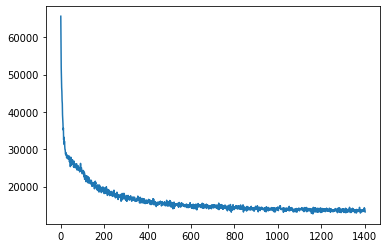

In [ ]:
vae = ConvVAE()
vae.to(device)
batch_size=128
optim = torch.optim.Adam(vae.parameters(),lr=1e-3,weight_decay=1e-5)
loss_fn = nn.MSELoss()
dataloader = DataLoader(mnist,batch_size=batch_size,shuffle=True, drop_last=True)
losses = []
for epoch in range(3):
    for im_batch, _ in tqdm(dataloader):
        im_batch = im_batch.to(device)
        optim.zero_grad()
        
        # Get the reconstruction as well as the predicted distribution (mean and logvar):
        reconstruction, mean, logvar = vae(im_batch, return_dist=True) 
            
        # Reconstruction loss
        BCE = F.binary_cross_entropy(reconstruction, im_batch, reduction='sum')
        
        # KL Divergence
        KLD = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
        
        # Combine the two to get final loss
        loss = BCE + KLD
        losses.append(loss.item())
        loss.backward()
        optim.step()
plt.plot(losses)

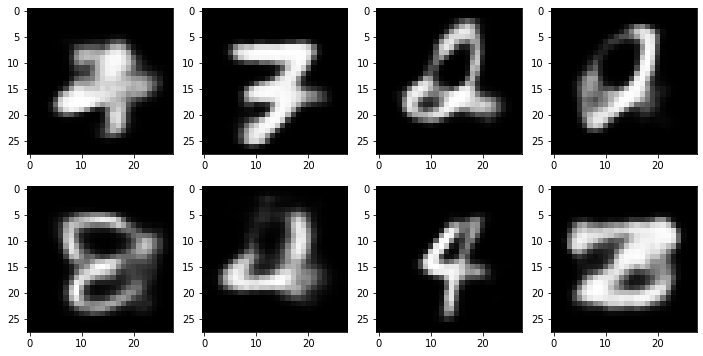

In [ ]:
# Generate new images from random zs
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
for i in range(8):
    im = vae.decode(torch.randn(1, 20).to(device)) # Random point
    axs[i//4][i%4].imshow(im.detach().cpu().squeeze(), cmap='gray')

As you can see, these outputs look much more like digits than the non-variational equivalent! We have successfully trained a model that can turn a random noise input into a plausible looking image. 

**Exercise**: Try some experiments based on the code above. For example: <br>
- What happens if you use a low hidden dimension size (say, 5, or 2) - can the model still reconstruct images well? How diverse are the generated images? 
- Can you make a linear version (no convolutions) of the VAE above? You'll need to flatten the input images and think about how many inputs and outputs each layer should have (the official PyTorch vae example is a good reference if you get stuck)
- How good can you get? Use the test set of MNIST and measure reconstruction loss (with something like MSE between the inages and the encoded-then-decoded versions) or generate a bunch of examples and visually assess them. 
- Try this o a dataset of color images - perhaps faces. Do any issues stand out that aren't apparent with a simple dataset like MNIST? 

In [ ]:
# Your code here

Page stats: Total Hits: [![HitCount](https://hits.dwyl.com/johnowhitaker/tglcourse.svg?style=flat-square&show=unique)](http://hits.dwyl.com/johnowhitaker/tglcourse)
Page visitors:
![visitor badge](https://page-views.glitch.me/badge?page_id=tglcourse.l06)